In [1]:
# Import the various dependencies and setup
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# Create Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
connection = engine.connect()

In [4]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

The last date precipitation data was captured ('2017-08-23',)
This results in the start date of 2016-08-23


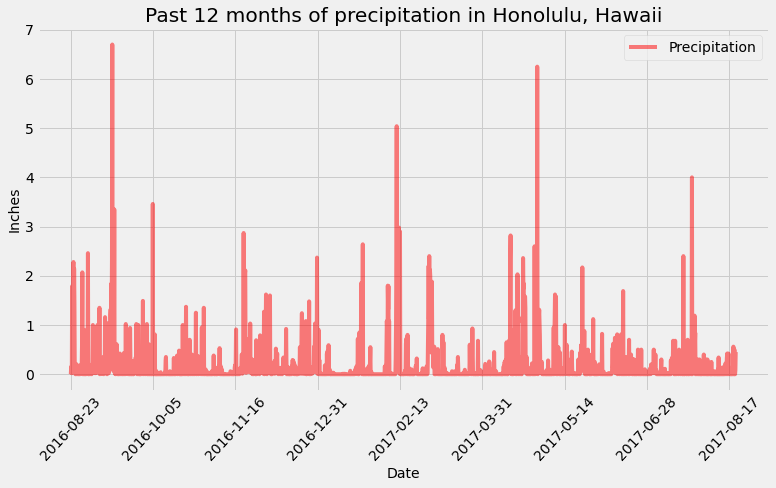

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Retrieve and print the last date precipitation data was captured
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print (f"The last date precipitation data was captured", end_date)

# Calculate and print the date 1 year ago from the last data point in the database
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print (f"This results in the start date of", start_date)

# Perform a query to retrieve the data and precipitation scores
climate_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(climate_data, columns = ["Date", "Precipitation"])

# Sort the dataframe by date and drop rows with missing data
climate_df.set_index("Date", inplace=True)
climate_df.sort_index()
climate_df = climate_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
Honolulu_data = climate_df.plot (color = "red", alpha = .5, figsize = (11,7))

# Set the title, legend and x & y axis labels
plt.title("Past 12 months of precipitation in Honolulu, Hawaii")
plt.legend(["Precipitation"], loc = "best")
plt.xlabel("Date", fontsize = 14)
plt.xticks(fontsize = 14, rotation = 47)
plt.ylabel("Inches", fontsize = 14)

# Show and resize the plot
plt.tight_layout()
plt.show()

In [9]:
# Use Pandas to calculate the summary statistics for the precipitation data
climate_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [10]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print ("There are " + str(stations) + " stations available in this dataset.")

There are 9 stations available in this dataset.


In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order.
station_df = pd.DataFrame(active_stations, columns=["Station ID", "Total observations"])
station_df.sort_values(["Total observations"], ascending=False)

# Drop rows with missing data
station_df = station_df.dropna()
station_df

,Station ID,Total observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

min_tobs = session.query(func.min(Measurement.tobs).filter(Measurement.station=='USC00519281')).all()
max_tobs = session.query(func.max(Measurement.tobs).filter(Measurement.station=='USC00519281')).all()                          
avg_tobs = session.query(func.avg(Measurement.tobs).filter(Measurement.station=='USC00519281')).all()

print("Lowest Temperature at Station ID USC00519281 was", min_tobs)
print("Highest Temperature at Station ID USC00519281 was", max_tobs)
print("Average Temperature at Station ID USC00519281 was", avg_tobs)

Lowest Temperature at Station ID USC00519281 was [(54.0,)]
Highest Temperature at Station ID USC00519281 was [(85.0,)]
Average Temperature at Station ID USC00519281 was [(71.66378066378067,)]


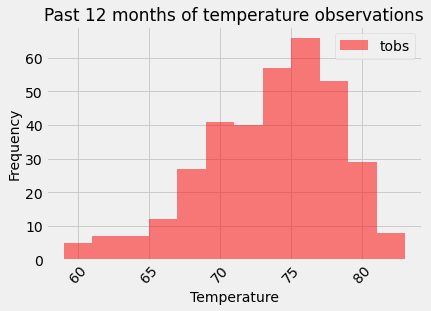

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the last 12 months of temperature observations
last_twelve_months_tobs = session.query(Measurement.station, Measurement.tobs).\
                        filter(Measurement.station=='USC00519281').filter(Measurement.date >= start_date).all()
tobs_df = pd.DataFrame(last_twelve_months_tobs)
tobs_df.set_index('station', inplace=True)
tobs_df.sort_index()
tobs_df.head()

# Plot a histogram of the last 12 months of temperature observation data
plt.hist(tobs_df['tobs'], bins = 12, color = "red", alpha = .5)

# Set the title, legend and x & y axis labels
plt.title("Past 12 months of temperature observations", fontsize = 17)
plt.legend(["tobs"], loc = "best")
plt.xlabel("Temperature", fontsize = 14)
plt.xticks(fontsize = 14, rotation = 47)
plt.ylabel("Frequency", fontsize = 14)

# Show and resize the plot
plt.show()

## Bonus Challenge Assignment

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [15]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [16]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [17]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [18]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [19]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [20]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [21]:
# Plot the daily normals as an area plot with `stacked=False`
